In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
import keras_tuner as kt

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import KFold


In [2]:
ds_dir = '../Datasets/5-classes'
img_height = 256
img_width = 256

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=ds_dir + '/Train',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=sum(len(files) for _, _, files in os.walk(ds_dir + '/Train')),
    image_size=(img_height, img_width)
)
validation_ds = keras.utils.image_dataset_from_directory(
    directory=ds_dir + '/Val',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=sum(len(files) for _, _, files in os.walk(ds_dir + '/Val')),
    image_size=(img_height, img_width)
)
test_ds = keras.utils.image_dataset_from_directory(
    directory=ds_dir + '/Test',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=sum(len(files) for _, _, files in os.walk(ds_dir + '/Test')),
    image_size=(img_height, img_width)
)

Found 2020 files belonging to 5 classes.
Found 500 files belonging to 5 classes.
Found 1035 files belonging to 5 classes.


In [5]:
for x, y in train_ds:
    x_train = x.numpy()
    y_train = y.numpy()

for x, y in validation_ds:
    x_val = x.numpy()
    y_val = y.numpy()

for x, y in test_ds:
    x_test = x.numpy()
    y_test = y.numpy()


In [6]:
normalize = lambda ds: ds / 255

x_train = normalize(x_train)
x_val = normalize(x_val)
x_test = normalize(x_test)

In [7]:
flatten = lambda ds: ds.reshape((-1, ds.shape[1] ** 2))

print(f'{x_train.shape=}')
print(f'{x_test.shape=}')

x_train = flatten(x_train)
x_val = flatten(x_val)
x_test = flatten(x_test)

print(f'new {x_train.shape=}')
print(f'new {x_test.shape=}')

x_train.shape=(2020, 256, 256, 1)
x_test.shape=(1035, 256, 256, 1)
new x_train.shape=(2020, 65536)
new x_test.shape=(1035, 65536)


### K-Fold

In [8]:
def create_model():
    model = Sequential()
    model.add(Dense(8, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model


In [9]:
n_folds = 10

results = []

x_train_val = np.concatenate((x_train, x_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

print(f'{x_train_val.shape=}')
print(f'{y_train_val.shape=}')

x_train_val.shape=(2520, 65536)
y_train_val.shape=(2520, 5)


In [10]:
def generate_actual_predicted(model, X_test, Y_test):
    Y_pred = model.predict(X_test)

    predicted = []
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
    
    actual = []
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
    
    return actual, predicted

In [11]:
for train_index, test_index in KFold(n_folds).split(x_train_val):
    x_tr, x_ts = x_train_val[train_index], x_train_val[test_index]
    y_tr, y_ts = y_train_val[train_index], y_train_val[test_index]
    
    model = create_model()
    model.fit(x_tr, y_tr, epochs=30, batch_size=128)
    
    scores = model.evaluate(x_test,y_test)

    for i, names in zip(np.arange(0, len(model.metrics_names)), model.metrics_names):
        print(model.metrics_names[i],'=',scores[i])

    actual, predicted = generate_actual_predicted(model, x_ts, y_ts)

    precision = precision_score(actual, predicted, average='macro')
    recall = recall_score(actual, predicted, average='macro')
    f1_score_ = f1_score(actual, predicted, average='macro')

    print(f'{precision=}')
    print(f'{recall=}')
    print(f'{f1_score_=}')

    results.append([model, precision, recall, f1_score_])

Epoch 1/30
18/18 [==============================] - 3s 22ms/step - loss: 2.0929 - accuracy: 0.1839
Epoch 2/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6096 - accuracy: 0.1993
Epoch 3/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6096 - accuracy: 0.1993
Epoch 4/30
18/18 [==============================] - 0s 25ms/step - loss: 1.6095 - accuracy: 0.1993
Epoch 5/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6095 - accuracy: 0.1852
Epoch 6/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6095 - accuracy: 0.1896
Epoch 7/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6095 - accuracy: 0.1993
Epoch 8/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6095 - accuracy: 0.1993
Epoch 9/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6095 - accuracy: 0.1962
Epoch 10/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6094 - accuracy: 0.2059
Epoch 11/

D:\Python Projects\virtualenvs\.AI_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision=0.029365079365079365
recall=0.2
f1_score_=0.05121107266435987
Epoch 1/30
18/18 [==============================] - 1s 22ms/step - loss: 3.9397 - accuracy: 0.1993
Epoch 2/30
18/18 [==============================] - 0s 22ms/step - loss: 1.8136 - accuracy: 0.2284
Epoch 3/30
18/18 [==============================] - 0s 23ms/step - loss: 1.5698 - accuracy: 0.3034
Epoch 4/30
18/18 [==============================] - 0s 21ms/step - loss: 1.5368 - accuracy: 0.3422
Epoch 5/30
18/18 [==============================] - 0s 22ms/step - loss: 1.5439 - accuracy: 0.3325
Epoch 6/30
18/18 [==============================] - 0s 21ms/step - loss: 1.5114 - accuracy: 0.3382
Epoch 7/30
18/18 [==============================] - 0s 21ms/step - loss: 1.4947 - accuracy: 0.3461
Epoch 8/30
18/18 [==============================] - 0s 21ms/step - loss: 1.5162 - accuracy: 0.3351
Epoch 9/30
18/18 [==============================] - 0s 21ms/step - loss: 1.5135 - accuracy: 0.3263
Epoch 10/30
18/18 [==================

D:\Python Projects\virtualenvs\.AI_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
18/18 [==============================] - 1s 21ms/step - loss: 4.3134 - accuracy: 0.2368
Epoch 2/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6048 - accuracy: 0.3519
Epoch 3/30
18/18 [==============================] - 0s 22ms/step - loss: 1.4166 - accuracy: 0.3849
Epoch 4/30
18/18 [==============================] - 0s 21ms/step - loss: 1.3881 - accuracy: 0.4004
Epoch 5/30
18/18 [==============================] - 0s 21ms/step - loss: 1.3697 - accuracy: 0.3920
Epoch 6/30
18/18 [==============================] - 0s 22ms/step - loss: 1.3470 - accuracy: 0.4123
Epoch 7/30
18/18 [==============================] - 0s 20ms/step - loss: 1.3528 - accuracy: 0.4083
Epoch 8/30
18/18 [==============================] - 0s 24ms/step - loss: 1.3028 - accuracy: 0.4462
Epoch 9/30
18/18 [==============================] - 0s 24ms/step - loss: 1.3435 - accuracy: 0.4034
Epoch 10/30
18/18 [==============================] - 0s 20ms/step - loss: 1.2793 - accuracy: 0.4528
Epoch 11/

D:\Python Projects\virtualenvs\.AI_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
18/18 [==============================] - 1s 22ms/step - loss: 2.4540 - accuracy: 0.1944
Epoch 2/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6094 - accuracy: 0.2002
Epoch 3/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6095 - accuracy: 0.1962
Epoch 4/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6095 - accuracy: 0.1927
Epoch 5/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6095 - accuracy: 0.2002
Epoch 6/30
18/18 [==============================] - 0s 24ms/step - loss: 1.6095 - accuracy: 0.2033
Epoch 7/30
18/18 [==============================] - 0s 24ms/step - loss: 1.6094 - accuracy: 0.2033
Epoch 8/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6094 - accuracy: 0.2033
Epoch 9/30
18/18 [==============================] - 0s 24ms/step - loss: 1.6094 - accuracy: 0.2033
Epoch 10/30
18/18 [==============================] - 0s 25ms/step - loss: 1.6095 - accuracy: 0.2033
Epoch 11/

D:\Python Projects\virtualenvs\.AI_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
18/18 [==============================] - 1s 20ms/step - loss: 3.1816 - accuracy: 0.2086
Epoch 2/30
18/18 [==============================] - 0s 20ms/step - loss: 1.6095 - accuracy: 0.1993
Epoch 3/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6095 - accuracy: 0.1993
Epoch 4/30
18/18 [==============================] - 0s 24ms/step - loss: 1.6095 - accuracy: 0.1993
Epoch 5/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6095 - accuracy: 0.1993
Epoch 6/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6095 - accuracy: 0.1914
Epoch 7/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6094 - accuracy: 0.2024
Epoch 8/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6095 - accuracy: 0.1927
Epoch 9/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6094 - accuracy: 0.1993
Epoch 10/30
18/18 [==============================] - 0s 24ms/step - loss: 1.6094 - accuracy: 0.1993
Epoch 11/

D:\Python Projects\virtualenvs\.AI_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
18/18 [==============================] - 1s 21ms/step - loss: 2.2624 - accuracy: 0.1896
Epoch 2/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6094 - accuracy: 0.1997
Epoch 3/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6094 - accuracy: 0.1958
Epoch 4/30
18/18 [==============================] - 0s 24ms/step - loss: 1.6094 - accuracy: 0.2028
Epoch 5/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6094 - accuracy: 0.2028
Epoch 6/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6094 - accuracy: 0.2028
Epoch 7/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6094 - accuracy: 0.2028
Epoch 8/30
18/18 [==============================] - 0s 24ms/step - loss: 1.6094 - accuracy: 0.2028
Epoch 9/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6094 - accuracy: 0.2028
Epoch 10/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6094 - accuracy: 0.2028
Epoch 11/

D:\Python Projects\virtualenvs\.AI_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
18/18 [==============================] - 1s 21ms/step - loss: 2.7172 - accuracy: 0.2086
Epoch 2/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6095 - accuracy: 0.2002
Epoch 3/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6095 - accuracy: 0.2002
Epoch 4/30
18/18 [==============================] - 0s 24ms/step - loss: 1.6095 - accuracy: 0.2002
Epoch 5/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6095 - accuracy: 0.2002
Epoch 6/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6095 - accuracy: 0.2002
Epoch 7/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6095 - accuracy: 0.2002
Epoch 8/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6094 - accuracy: 0.2002
Epoch 9/30
18/18 [==============================] - 0s 20ms/step - loss: 1.6095 - accuracy: 0.2002
Epoch 10/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6094 - accuracy: 0.2002
Epoch 11/

D:\Python Projects\virtualenvs\.AI_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
18/18 [==============================] - 1s 20ms/step - loss: 2.6046 - accuracy: 0.1944
Epoch 2/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6096 - accuracy: 0.1958
Epoch 3/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6096 - accuracy: 0.2015
Epoch 4/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6096 - accuracy: 0.2015
Epoch 5/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6096 - accuracy: 0.2015
Epoch 6/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6096 - accuracy: 0.2015
Epoch 7/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6096 - accuracy: 0.2015
Epoch 8/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6095 - accuracy: 0.2015
Epoch 9/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6095 - accuracy: 0.2015
Epoch 10/30
18/18 [==============================] - 0s 26ms/step - loss: 1.6095 - accuracy: 0.2015
Epoch 11/

D:\Python Projects\virtualenvs\.AI_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
18/18 [==============================] - 1s 23ms/step - loss: 2.5525 - accuracy: 0.1940
Epoch 2/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6094 - accuracy: 0.1989
Epoch 3/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6094 - accuracy: 0.1989
Epoch 4/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6094 - accuracy: 0.1975
Epoch 5/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6094 - accuracy: 0.2037
Epoch 6/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6094 - accuracy: 0.2037
Epoch 7/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6094 - accuracy: 0.2037
Epoch 8/30
18/18 [==============================] - 0s 22ms/step - loss: 1.6094 - accuracy: 0.2037
Epoch 9/30
18/18 [==============================] - 0s 21ms/step - loss: 1.6094 - accuracy: 0.2037
Epoch 10/30
18/18 [==============================] - 0s 23ms/step - loss: 1.6094 - accuracy: 0.2037
Epoch 11/

D:\Python Projects\virtualenvs\.AI_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


prec=array([0.029365079365079365, 0.24559178743961355, 0.4477635264632169,
       0.031746031746031744, 0.03412698412698413, 0.03571428571428571,
       0.03492063492063492, 0.03412698412698413, 0.03253968253968254,
       0.03333333333333333], dtype=object)
recl=array([0.2, 0.3454415954415954, 0.3927288609364081, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2], dtype=object)


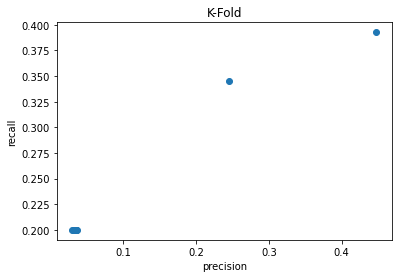

min precision =  0.029365079365079365
min recall =  0.2
max precision =  0.4477635264632169
max recall =  0.3927288609364081
average precision =  0.09592283297758462 sd= 0.13328913171421175
average recall =  0.23381704563780037 sd= 0.06845563947970344


In [12]:
res = np.array(results)

prec = res[:,1]
print(f'{prec=}')
recl = res[:,2]
print(f'{recl=}')

plt.scatter(prec, recl)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('K-Fold') 
plt.show()

print('min precision = ', prec.min())
print('min recall = ', recl.min())
print('max precision = ', prec.max())
print('max recall = ', recl.max())
print('average precision = ', prec.mean(), 'sd=', prec.std())
print('average recall = ', recl.mean(),'sd=', recl.std())

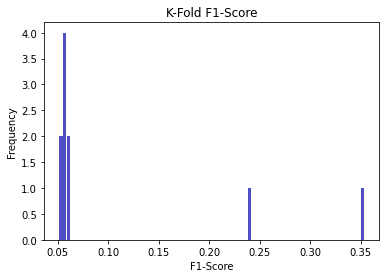

F1-Score = 0.10484988176725678 standard deviation = 0.09911361135465531


In [13]:
res = np.array(results)
f1_score = res[:,3]
plt.hist(x=f1_score, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('K-Fold F1-Score')
plt.ylabel('Frequency')
plt.xlabel('F1-Score')
plt.show()
print('F1-Score =', f1_score.mean(), 'standard deviation =', f1_score.std())

res_model1 = res

In [14]:
best_model = res[np.argmax(res[:,2]), 0]
best_model.evaluate(
    x_test, y_test
)

33/33 [==============================] - 0s 4ms/step - loss: 1.6791 - accuracy: 0.2841


[1.6790614128112793, 0.28405797481536865]

In [15]:
def build_model(hp):
    model = Sequential()
    model.add(
        Dense(
            units=hp.Int('units', min_value=4, max_value=32, step=4),
            input_dim=x_train.shape[1],
            activation=hp.Choice('layer1', ['relu', 'sigmoid', 'tanh'])
        )
    )
    model.add(
        Dense(
            units=hp.Int('units', min_value=8, max_value=64, step=8),
            activation=hp.Choice('layer2', ['relu', 'sigmoid', 'tanh'])
        )
    )
    model.add(Dense(5, activation=hp.Choice('outputlayer', ['relu', 'softmax'])))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

In [18]:
trial_histories = {}

class CustomTuner(kt.RandomSearch):
    def fit_trial(self, trial, *args, **kwargs):
        histories = super.fit_trial(self, trial, args, kwargs)
        trial_histories[trial] = histories
        return histories

In [19]:
tuner = CustomTuner(
    build_model,
    objective='val_loss',
    max_trials=32,
    executions_per_trial=1,
    directory='my_dir',
    project_name='x_ray_keras_hw',
    overwrite=True
)

In [20]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 4, 'sampling': None}
layer1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
layer2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
outputlayer (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'softmax'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [21]:
tuner.search(
    x_train,
    y_train,
    epochs=30,
    validation_data=(x_val, y_val)
)

Trial 5 Complete [00h 01m 20s]
val_loss: 1.5699851115544636

Best val_loss So Far: 1.5699851115544636
Total elapsed time: 00h 06m 52s
INFO:tensorflow:Oracle triggered exit


In [22]:
tuner.results_summary()

Results summary
Results in my_dir\x_ray_keras_hw
Showing 10 best trials
Trial summary
Hyperparameters:
units: 16
layer1: relu
layer2: sigmoid
outputlayer: softmax
lr: 0.0013201307778650327
Score: 1.5699851115544636
Trial summary
Hyperparameters:
units: 28
layer1: sigmoid
layer2: tanh
outputlayer: relu
lr: 0.0047987796433212595
Score: 3.4278239409128823
Trial summary
Hyperparameters:
units: 16
layer1: tanh
layer2: relu
outputlayer: relu
lr: 0.0006771925396670594
Score: 9.035763581593832
Trial summary
Hyperparameters:
units: 12
layer1: sigmoid
layer2: tanh
outputlayer: relu
lr: 0.007537119294169523
Score: 9.0584184328715
Trial summary
Hyperparameters:
units: 12
layer1: relu
layer2: relu
outputlayer: relu
lr: 0.00013173668323775218
Score: nan


In [23]:
best_model = tuner.get_best_models()[0]

### Summary

In [ ]:
trial_histories

In [25]:
# history = best_model.fit(
#     x_train, y_train,
#     batch_size=32,
#     validation_data=(x_val, y_val),
#     epochs=50
# )

score = best_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
def generate_actual_predicted(model, X_test, Y_test):
    Y_pred = model.predict(X_test)

    predicted = []
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
    
    actual = []
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
    
    return actual, predicted

actual, predicted = generate_actual_predicted(model, x_test, y_test)


Epoch 1/50
64/64 [==============================] - 1s 12ms/step - loss: 1.6073 - accuracy: 0.1896 - val_loss: 1.6078 - val_accuracy: 0.2180
Epoch 2/50
64/64 [==============================] - 1s 14ms/step - loss: 1.5893 - accuracy: 0.2347 - val_loss: 1.6087 - val_accuracy: 0.2080
Epoch 3/50
64/64 [==============================] - 1s 14ms/step - loss: 1.5481 - accuracy: 0.2752 - val_loss: 1.5958 - val_accuracy: 0.2140
Epoch 4/50
60/64 [===========================>..] - ETA: 0s - loss: 1.4834 - accuracy: 0.3411

KeyboardInterrupt: 

In [ ]:
# score = best_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
def generate_actual_predicted(model, X_test, Y_test):
    Y_pred = model.predict(X_test)

    predicted = []
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
    
    actual = []
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
    
    return actual, predicted

actual, predicted = generate_actual_predicted(model, x_test, y_test)


### Evaluation Metrics

In [ ]:
from sklearn.metrics import f1_score

ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(actual,predicted)
).plot(cmap=plt.cm.Blues)
print(classification_report(actual,predicted))
print(accuracy_score(actual, predicted))
print(f1_score(actual, predicted, average='macro'))
print(precision_score(actual, predicted, average='macro'))
print(recall_score(actual, predicted, average='macro'))
print(classification_report(actual, predicted))


### Accuracy Curve

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Loss Curve

In [ ]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()